# Route visualization
## Data visualization

In [52]:
import json
import os
import random
import matplotlib.pyplot as plt

General atributes

In [53]:
TRIPS_GEOJSON_FILE_TV = "tripsGeojsonTV/"
TRIPS_GEOJSON_FILE_TC = "tripsGeojsonTC/"
ROTOGRAMS_FILES = "rotograms/"

HEAT_MAPS_DIRECTORY = "heatMaps/"

Clean heat maps

In [54]:
filelist = [ f for f in os.listdir(HEAT_MAPS_DIRECTORY)]
for f in filelist:
    os.remove(os.path.join(HEAT_MAPS_DIRECTORY, f))

### Load trips and rotograms files

Atributes

In [55]:
rotogramsDict = {}
tripsEmptyDict = {}
tripsFullDict = {}

Functions

In [56]:
def readJsonFile(filename, DIRECTORY):
    fileContent = open(os.path.join(DIRECTORY, filename), 'r')
    return json.loads(fileContent.read())

# ROTOGRAMS
def getOriginRotogramFileName(filename):
    return filename.split(".")[0].split("_")[0]

def getBlockRotogramFileName(filename):
    return filename.split(".")[0].split("_")[1]

def addRotogramToDict(origin, block, rotogramDataJson):
    if not origin in rotogramsDict:
        rotogramsDict[origin] = {}
        
    rotogramsDict[origin][block] = rotogramDataJson

def loadRotograms():
    for rotogramFileName in os.listdir(ROTOGRAMS_FILES):
        if(rotogramFileName == ".gitkeep"): continue
        rotogramContent = readJsonFile(rotogramFileName, ROTOGRAMS_FILES)
        
        origin = getOriginRotogramFileName(rotogramFileName)
        block = getBlockRotogramFileName(rotogramFileName)
        
        addRotogramToDict(origin, block, rotogramContent)

# TRIPS
def getOriginTripFileName(filename):
    return filename.split(".")[0].split("_")[0]

def getDestinationTripFileName(filename):
    return filename.split(".")[0].split("_")[3]

def getBlockTripFileName(filename):
    return filename.split(".")[0].split("_")[2]

def addTripToEmptyRouteList(origin, block, tripContent):
    if not origin in tripsEmptyDict:
        tripsEmptyDict[origin] = {}
        
    if not block in tripsEmptyDict[origin]:
        tripsEmptyDict[origin][block] = []
        
    tripsEmptyDict[origin][block].append(tripContent)

def addTripToFullRouteList(destination, block, tripContent):
    if not destination in tripsFullDict:
        tripsFullDict[destination] = {}
        
    if not block in tripsFullDict[destination]:
        tripsFullDict[destination][block] = []
        
    tripsFullDict[destination][block].append(tripContent)

def addTripTV(tripFileName, tripDataJson):
    origin = getOriginTripFileName(tripFileName)
    block = getBlockTripFileName(tripFileName)
    
    addTripToEmptyRouteList(origin, block, tripDataJson)
    
def addTripTC(tripFileName, tripDataJson):
    block = getBlockTripFileName(tripFileName)
    destination = getDestinationTripFileName(tripFileName)
    
    addTripToFullRouteList(destination, block, tripDataJson)

def loadTrips():
    for tripFileName in os.listdir(TRIPS_GEOJSON_FILE_TV):
        if(tripFileName == ".gitkeep"): continue
        tripContent = readJsonFile(tripFileName, TRIPS_GEOJSON_FILE_TV)
        addTripTV(tripFileName, tripContent)
        
    for tripFileName in os.listdir(TRIPS_GEOJSON_FILE_TC):
        if(tripFileName == ".gitkeep"): continue
        tripContent = readJsonFile(tripFileName, TRIPS_GEOJSON_FILE_TC)
        addTripTC(tripFileName, tripContent)

Execution

In [57]:
loadRotograms()
loadTrips()

### Make heat maps

In [58]:
def plotRoutes(rotogram, listPoints, origin, block, acutalPath):
    latitudeRotogram = []
    longitudeRotogram = []
    
    latitudeHeatMap = []
    longitudeHeatMap = []
    
    rotogramPoints = rotogram["features"][0]["geometry"]["coordinates"]
    
    for i in range(0, len(rotogramPoints)):
        longitudeRotogram.append(float(rotogramPoints[i][0]))
        latitudeRotogram.append(float(rotogramPoints[i][1]))
    
    for i in range(0, len(listPoints)):
        longitudeHeatMap.append(float(listPoints[i][0]))
        latitudeHeatMap.append(float(listPoints[i][1]))

    #Plota
    figId = random.randint(0, 10000000000000000)
    plt.figure(figId)
    
    plt.scatter(latitudeHeatMap, longitudeHeatMap, s=0.001,color="red", alpha=0.1)
#     olor=['red','green','blue']
    plt.plot(latitudeRotogram, longitudeRotogram, label='Rotograma',linewidth=0.2)
    
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()

    plt.title(origin+"_"+block+"_"+acutalPath)
    plt.savefig(HEAT_MAPS_DIRECTORY+origin+"_"+block+"_"+acutalPath+'.svg', dpi=6000)
#     fig1 = plt.gcf()
#     fig1.savefig('heatMaps/'+origin+"_"+block+"_"+acutalPath+'.png', dpi=100)

In [59]:
def existsTripsForRotogram(originOrDestination, block, tripsDict):
    if not originOrDestination in tripsDict: return False
    if not block in tripsDict[originOrDestination]: return False
    if len(tripsDict[originOrDestination][block]) == 0: return False
    return True

def getFullListOfPointsFromTracers(travels, actualPath):
    fullListPoints = []
    
    for travel in travels:
        fullListPoints.extend(travel["tracers"][actualPath]["geometry"]["coordinates"])
    
    return fullListPoints

def getListPointsFromTracers(origin, block, actualPath):
    if actualPath == "TRAJETO_VAZIO":
        if not existsTripsForRotogram(origin, block, tripsEmptyDict): return []
        travels = tripsEmptyDict[origin][block]
        return getFullListOfPointsFromTracers(travels, actualPath)
    else:
        if not existsTripsForRotogram(origin, block, tripsFullDict): return []
        travels = tripsFullDict[origin][block]
        return getFullListOfPointsFromTracers(travels, actualPath)

def makeHeatMaps():
    for origin in rotogramsDict:
        for block in rotogramsDict[origin]:
            rotogram = rotogramsDict[origin][block]
            
            listPointsEmptyPath = getListPointsFromTracers(origin, block, "TRAJETO_VAZIO")
            if len(listPointsEmptyPath) > 0:
                plotRoutes(rotogram, listPointsEmptyPath, origin, block, "TRAJETO_VAZIO")
            
            listPointsFullPath = getListPointsFromTracers(origin, block, "TRAJETO_CARREGADO")
            if len(listPointsFullPath) > 0:
                plotRoutes(rotogram, listPointsFullPath, origin, block, "TRAJETO_CARREGADO")

/home/brunolippert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


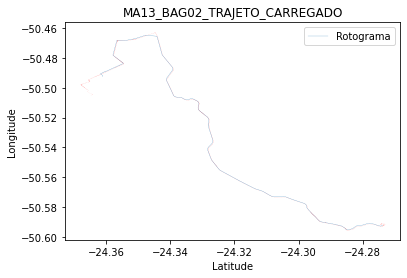

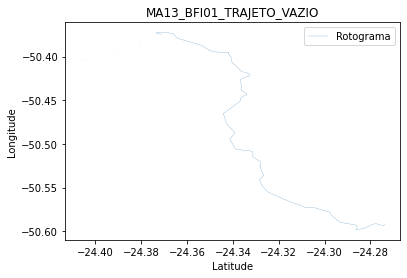

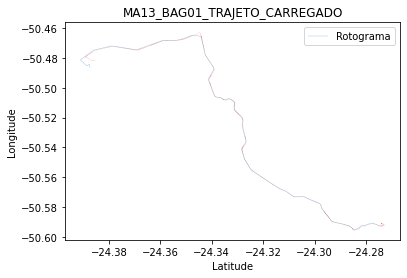

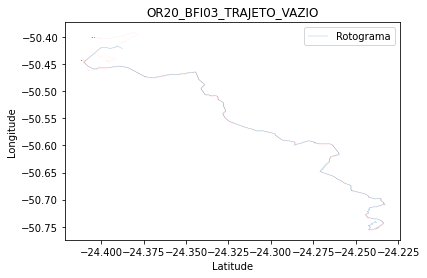

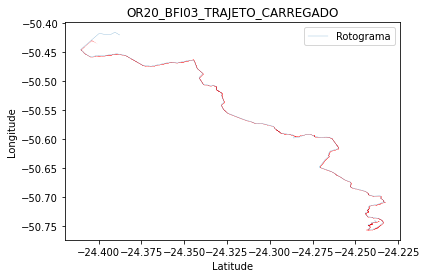

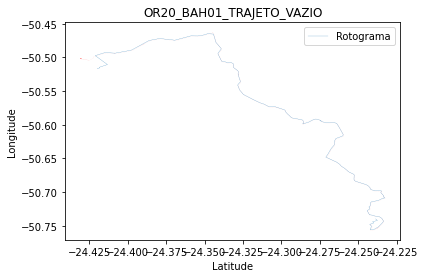

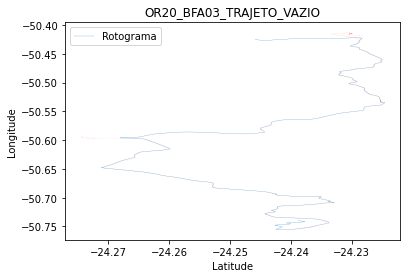

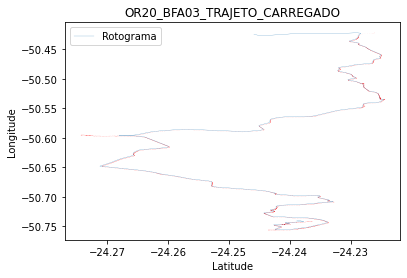

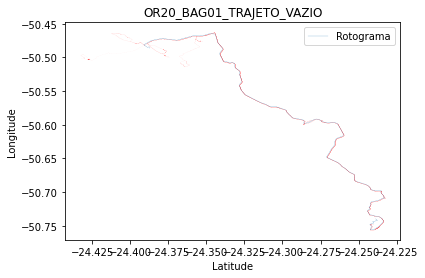

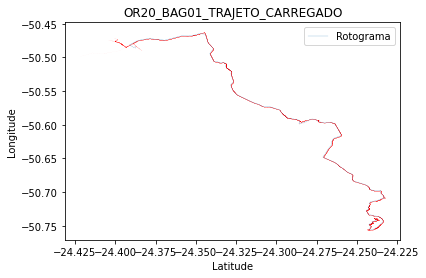

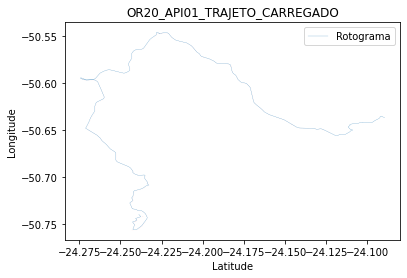

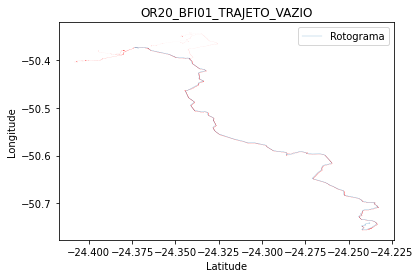

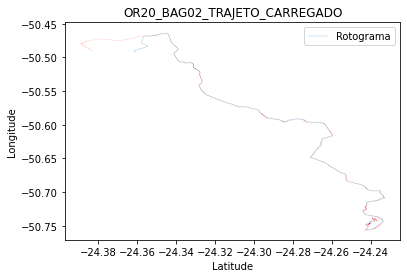

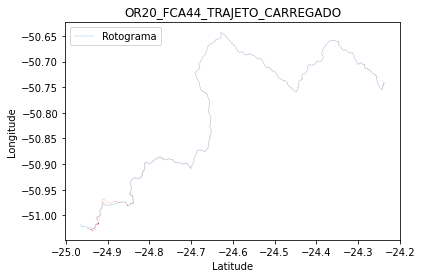

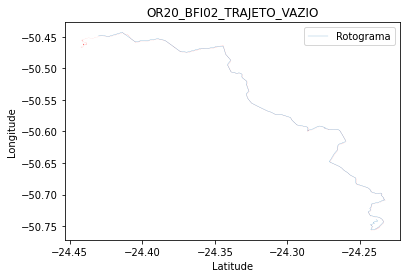

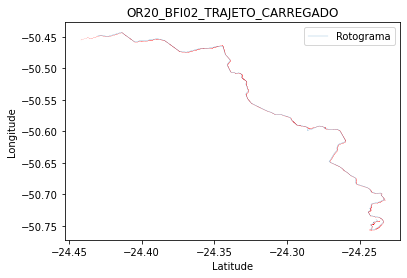

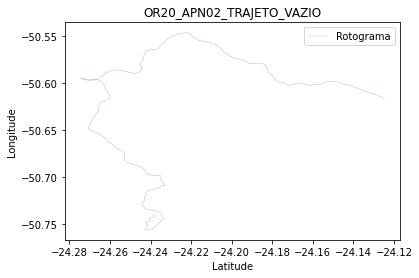

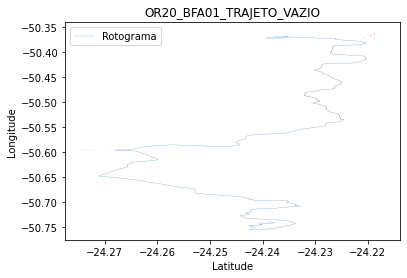

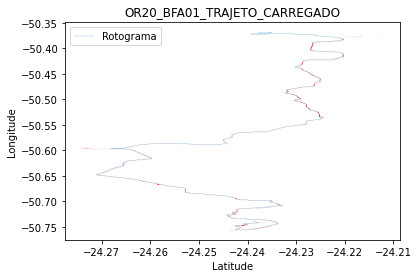

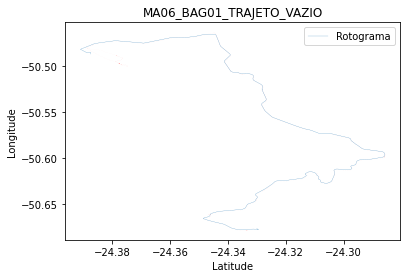

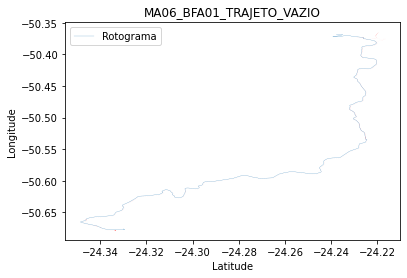

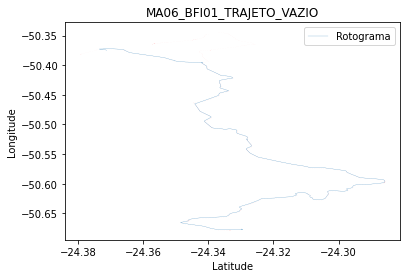

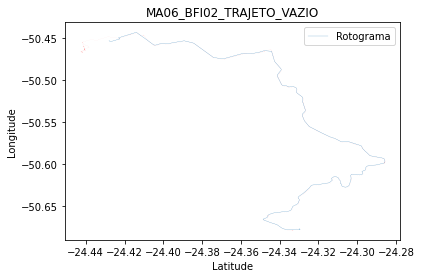

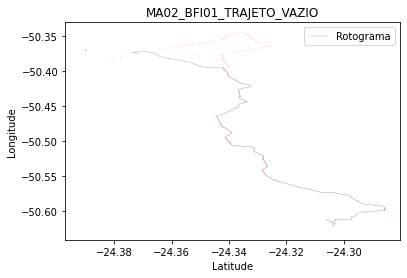

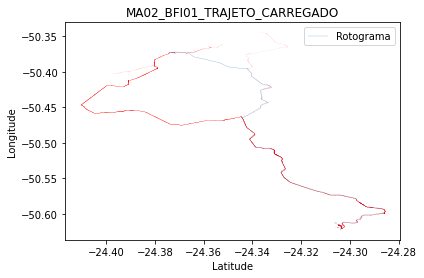

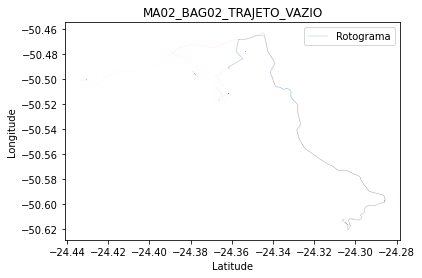

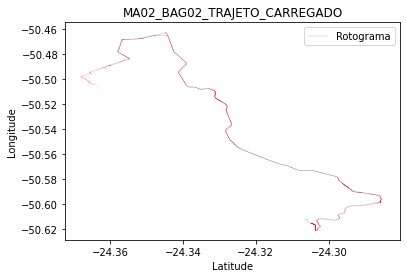

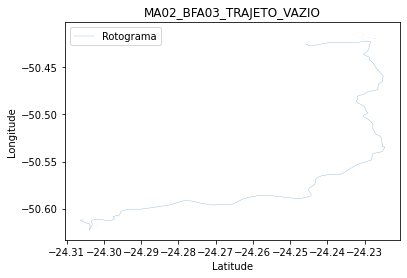

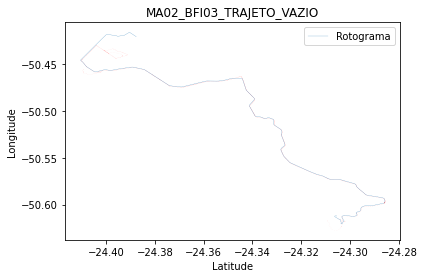

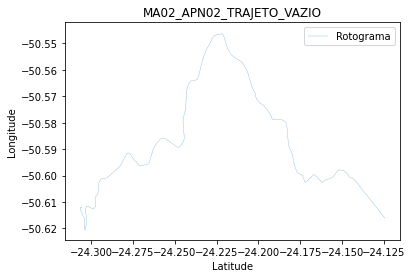

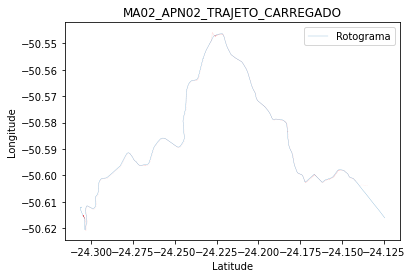

In [60]:
 makeHeatMaps()